In [1]:
# imports
import numpy as np
from math import comb, exp
from functools import lru_cache
import time
try:
    from tqdm import tqdm
    use_tqdm = True
except:
    use_tqdm = False
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm
import os
import glob
# import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [2]:
"""
ntg_part1.py
Part 1 for reproducing:
  - payoff functions π_I, π_T, π_U
  - hypergeometric group sampling probability
  - expected payoffs f_I, f_T, f_U (finite X)
  - mutation-selection imitation probability T_{A->B} (eq. 2.1)

Formulas taken from the manuscript (payoffs, hypergeometric probability, eq.2.1).
Cite: Liu et al., rsif-2024-0726.R1_Proof_hi.pdf (uploaded).
"""


# -------------------------
# Utility: safe comb and hypergeometric probability
# -------------------------
@lru_cache(maxsize=None)
def nCr(n, r):
    if r < 0 or r > n:
        return 0
    return comb(n, r)

def hypergeom_prob(X_minus1, count_I_pool, count_T_pool, draws_N_minus1, NI, NT):
    """
    P(X-1, iI-1, iT, N-1, NI, NT) from the paper
    where:
      - X_minus1 = X - 1
      - count_I_pool = iI - 1  (for focal investor) OR iI (for other payoff calc)
      - count_T_pool = iT      (depending on focal)
      - draws_N_minus1 = N - 1
      - NI, NT are counts drawn from those pools (nonnegative ints)
    formula:
      C(count_I_pool, NI) * C(count_T_pool, NT) * C(X - iI - iT, draws_N_minus1 - NI - NT)
      -------------------------------------------------------------------------------
                              C(X_minus1, draws_N_minus1)
    """
    numerator = nCr(count_I_pool, NI) * nCr(count_T_pool, NT) * nCr(
        X_minus1 - count_I_pool - count_T_pool, draws_N_minus1 - NI - NT
    )
    denom = nCr(X_minus1, draws_N_minus1)
    if denom == 0:
        return 0.0
    return numerator / denom

# -------------------------
# Model payoff functions πI, πT, πU
# (these match Eqns in the paper; OT(NT) and OU(NT) defined by alpha, M)
# -------------------------
def OT(NT, alpha, M):
    # reward factor function O_T(NT) from manuscript
    # OT(NT) = 1 - alpha  if NT + 1 < M
    #         = alpha      if NT + 1 >= M
    return (1 - alpha) if (NT + 1 < M) else alpha

def OU(NT, alpha, M):
    # punishment factor O_U(NT)
    # OU(NT) = -alpha     if NT < M
    #        = alpha - 1  if NT >= M
    return (-alpha) if (NT < M) else (alpha - 1)

def payoff_pi_I(NI, NT, NU, params):
    """
    pi_I:
      - if NI == N-1: payoff = -delta
      - else: payoff = (RT*NT/(N-1-NI) * tv) - tv - delta  [careful with indices]
    Note: the paper uses expression RT * NT / (NT+NU+1) * tv returned to each investor.
    But in the πI formula the factor shown maps to RT*NT/(N-1-NI) in the snippet; to match paper
    we implement according to the expression in the PDF:
       πI = -δ  if NI == N-1
       otherwise: (RT * NT / (N - 1 - NI)) * tv - tv - δ
    """
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    if NI == N - 1:
        return - delta
    denom = (N - 1 - NI)
    # Avoid division by zero (should be protected by NI != N-1)
    return (RT * NT / denom) * tv - tv - delta

def payoff_pi_T(NI, NT, NU, params):
    """
    πT:
      - if NI == 0: payoff = -delta (no investors to get returns)
      - else: RT * NI / (N - NI) * tv - delta + N*delta/(NT+1) * OT(NT)
    Implementation follows the formula snippet in the PDF.
    """
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    # N*delta/(NT + 1) * OT(NT)
    incentive_term = (N * delta) / (NT + 1) * OT(NT, alpha, M)
    return (RT * NI / denom) * tv - delta + incentive_term

def payoff_pi_U(NI, NT, NU, params):
    """
    πU:
      - if NI == 0: payoff = -delta
      - else: RU * NI / (N - NI) * tv - delta + N*delta/(NU+1) * OU(NT)
    Note: OU depends on NT (the number of trustworthy trustees).
    """
    RU = params['RU']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    incentive_term = (N * delta) / (NU + 1) * OU(NT, alpha, M)
    return (RU * NI / denom) * tv - delta + incentive_term

# -------------------------
# Expected payoffs fI, fT, fU (sum over NI, NT using hypergeometric)
# fI uses P(X-1, iI-1, iT, N-1, NI, NT)
# fT uses P(X-1, iI, iT-1, N-1, NI, NT)
# fU uses P(X-1, iI, iT, N-1, NI, NT)
# -------------------------
def expected_payoffs(iI, iT, X, params):
    """
    Compute (fI, fT, fU) for population state counts (iI, iT, iU = X - iI - iT)
    Returns tuple of floats (fI, fT, fU).
    """
    N = params['N']
    iU = X - iI - iT
    Xm1 = X - 1
    draws = N - 1

    fI = 0.0
    fT = 0.0
    fU = 0.0

    # NI runs 0..N-1, NT runs 0..N-1-NI
    for NI in range(0, draws + 1):
        for NT in range(0, draws - NI + 1):
            NU = draws - NI - NT
            # probabilities depend on focal type (counts in pool differ)
            p_I = hypergeom_prob(Xm1, iI - 1, iT, draws, NI, NT)  # for focal investor
            p_T = hypergeom_prob(Xm1, iI, iT - 1, draws, NI, NT)  # for focal trustworthy trustee
            p_U = hypergeom_prob(Xm1, iI, iT, draws, NI, NT)      # for focal untrustworthy trustee

            # compute payoffs for that group composition
            pi_I = payoff_pi_I(NI, NT, NU, params)
            pi_T = payoff_pi_T(NI, NT, NU, params)
            pi_U = payoff_pi_U(NI, NT, NU, params)

            fI += p_I * pi_I
            fT += p_T * pi_T
            fU += p_U * pi_U

    return fI, fT, fU

# -------------------------
# Mutation-selection imitation probability T_{A -> B} (eq. 2.1 in paper)
# TA->B = (1 - mu) * [ iA/X * iB/(X-1) * 1/(1+exp(-omega*(fB - fA))) ] + mu * iA/(2X)
# Note: paper's exact arrangement of factors uses iA/X and iB/(X-1) prefactors (we follow that)
# -------------------------
def T_A_to_B(iA, iB, X, fA, fB, mu, omega):
    """
    Compute probability that a participant who chooses A adopts B.
    """
    # avoid division by zero
    if X <= 1:
        return 0.0
    imitation = 0.0
    if X - 1 > 0:
        imitation = (iA / X) * (iB / (X - 1)) * (1.0 / (1.0 + np.exp(-omega * (fB - fA))))
    result = (1.0 - mu) * imitation + mu * (iA / (2.0 * X))
    return float(result)

# -------------------------
# Quick demonstration using default parameters from the paper figures:
# X=100, N=6, RU=6, RT=4, tv=1, mu=0.01, omega=10, delta variable, alpha, M
# -------------------------
if __name__ == "__main__":
    # default params (example)
    params = {
        'RT': 4.0,
        'RU': 6.0,
        'N' : 6,
        'tv': 1.0,
        'delta': 0.25,   # example
        'alpha': 0.0,    # pure reward example
        'M': 3          # threshold example
    }
    X = 100 # note: this param dictates the resolution of the computation, the higher the longer to run (default 100)
    # example population state: iI=2 investors, iT=10 trustworthy, remainder untrustworthy
    iI_example = 2
    iT_example = 10

    fI, fT, fU = expected_payoffs(iI_example, iT_example, X, params)
    print("Expected payoffs (fI, fT, fU) at state (iI={}, iT={}):".format(iI_example, iT_example))
    print(fI, fT, fU)

    # Example of computing T_{I->T} where we pick fI,fT and counts:
    mu = 0.01; omega = 10.0
    iA = iI_example
    iB = iT_example
    t_I_to_T = T_A_to_B(iA, iB, X, fI, fT, mu, omega)
    print("T_{I->T} =", t_I_to_T)


Expected payoffs (fI, fT, fU) at state (iI=2, iT=10):
-0.8418367346938774 -0.04718211212862792 -0.12778129552023051
T_{I->T} = 0.0020992924858048113


In [3]:
# ntg_part2_compute.py
# Part 2: build transition matrix P, compute stationary distribution (power iteration),
# compute mean frequencies and gradient-of-selection, save outputs to results_part2.npz.
#
# Requires: numpy, optionally tqdm for progress bar (pip install tqdm).
# If you already have Part 1 as a module, you can import expected_payoffs, T_A_to_B, etc.
# This file includes the functions from Part 1 for self-containment.

# -------------------------
# Build state list and index mapping
# states are (iI, iT) with iI >=0, iT >=0 and iI + iT <= X
# total_states = (X+1)(X+2)/2
# -------------------------
def enumerate_states(X):
    states = []
    for iI in range(0, X+1):
        for iT in range(0, X+1 - iI):
            states.append((iI, iT))
    index_of = {s: idx for idx, s in enumerate(states)}
    return states, index_of

# -------------------------
# Build transition matrix P (dense). For each state (iI,iT), compute outgoing probabilities:
# TU->I (iI+1, iT), TI->U (iI-1, iT), TU->T (iI, iT+1), TT->U (iI, iT-1),
# TI->T (iI-1, iT+1), TT->I (iI+1, iT-1)
# (only if resulting indices valid). Self-loop = 1 - sum(outgoing)
# -------------------------
def build_transition_matrix(X, params, mu, omega, show_progress=True):
    states, index_of = enumerate_states(X)
    S = len(states)
    P = np.zeros((S, S), dtype=np.float64)

    # We'll cache expected payoffs for each state
    if use_tqdm and show_progress:
        iterator = tqdm(states, desc="Building P")
    else:
        iterator = states

    for s in iterator:
        iI, iT = s
        idx = index_of[s]
        iU = X - iI - iT

        # compute expected payoffs once per state
        fI, fT, fU = expected_payoffs(iI, iT, X, params)

        # compute all TA->B probabilities (use counts for A and B in current state)
        # note: make sure iA and iB correspond to counts in the current state
        # (for I->T: focal is I, role model is T)
        T_I_to_T = T_A_to_B(iI, iT, X, fI, fT, mu, omega)
        T_I_to_U = T_A_to_B(iI, iU, X, fI, fU, mu, omega)

        T_T_to_I = T_A_to_B(iT, iI, X, fT, fI, mu, omega)
        T_T_to_U = T_A_to_B(iT, iU, X, fT, fU, mu, omega)

        T_U_to_I = T_A_to_B(iU, iI, X, fU, fI, mu, omega)
        T_U_to_T = T_A_to_B(iU, iT, X, fU, fT, mu, omega)

        # now map these to adjacent state transitions (check validity)
        total_out = 0.0

        # TU -> I : U becomes I -> (iI+1, iT)
        if iU >= 1 and iI + 1 <= X:
            s2 = (iI + 1, iT)
            P[idx, index_of[s2]] += T_U_to_I
            total_out += T_U_to_I

        # TI -> U : I becomes U -> (iI-1, iT)  (I->U)
        if iI >= 1 and iI - 1 >= 0:
            s2 = (iI - 1, iT)
            P[idx, index_of[s2]] += T_I_to_U
            total_out += T_I_to_U

        # TU -> T : U becomes T -> (iI, iT+1)
        if iU >= 1 and iT + 1 <= X:
            s2 = (iI, iT + 1)
            P[idx, index_of[s2]] += T_U_to_T
            total_out += T_U_to_T

        # TT -> U : T becomes U -> (iI, iT-1)
        if iT >= 1 and iT - 1 >= 0:
            s2 = (iI, iT - 1)
            P[idx, index_of[s2]] += T_T_to_U
            total_out += T_T_to_U

        # TI -> T : I becomes T -> (iI -1, iT +1)
        if iI >= 1 and (iI - 1) + (iT + 1) <= X:
            s2 = (iI - 1, iT + 1)
            P[idx, index_of[s2]] += T_I_to_T
            total_out += T_I_to_T

        # TT -> I : T becomes I -> (iI +1, iT -1)
        if iT >= 1 and (iI + 1) + (iT - 1) <= X:
            s2 = (iI + 1, iT - 1)
            P[idx, index_of[s2]] += T_T_to_I
            total_out += T_T_to_I

        # self-loop probability
        stay = 1.0 - total_out
        # numerical guard
        if stay < 0:
            # tiny negative due to rounding; clamp
            if stay > -1e-12:
                stay = 0.0
            else:
                # if more negative then warn and renormalize
                print("warning 1")
                # renormalize outgoing by scaling
                if total_out > 0:
                    scale = 1.0 / total_out
                    for j in range(S):
                        if P[idx, j] > 0:
                            P[idx, j] *= scale
                    stay = 0.0
                else:
                    stay = 1.0
        P[idx, idx] += stay

    return P, states, index_of

# -------------------------
# Power iteration to find stationary distribution
# ----------------------
#  default tol=1e-12, max_iter=20000
def find_stationary_dist_power(P, tol=1e-4, max_iter=20000, verbose=False):
    S = P.shape[0]
    # start uniform
    x = np.ones(S, dtype=np.float64) / S
    for it in range(max_iter):
        x_next = x @ P  # row-vector style
        diff = np.linalg.norm(x_next - x, 1)
        x = x_next
        if verbose and (it % 200 == 0):
            print(f"iter {it}, L1 diff = {diff:.3e}")
        if diff < tol:
            if verbose:
                print(f"converged in {it} iterations, diff={diff:.2e}")
            break
    # normalize
    x = x / x.sum()
    return x

# -------------------------
# Compute mean frequencies and gradient-of-selection
# gradient components:
#   Delta_T(state) = P(state -> state with iT+1) - P(state -> state with iT-1)
#   Delta_I(state) = P(state -> state with iI+1) - P(state -> state with iI-1)
# We'll compute these using P entries we constructed.
# -------------------------
def compute_summary_and_gradients(P, states, index_of, X):
    S = len(states)
    # stationary dist computed earlier and passed; but here we only compute gradients and mean freqs given stationary
    # function will compute mean frequencies and gradients given P and states after we compute stationary dist.
    # We'll return arrays: mean_rho (I,T,U), gradient_I, gradient_T
    return None

# -------------------------
# Main runner: build P, compute stationary dist, compute means and gradient arrays, save to file
# -------------------------
def main_compute_and_save(X=100, params=None, mu=0.01, omega=10.0, out_filename="results_part2.npz"):
    if params is None:
        params = {'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':0.25, 'alpha':0.0, 'M':3}
    t0 = time.time()
    P, states, index_of = build_transition_matrix(X, params, mu, omega, show_progress=True)
    t1 = time.time()
    print(f"P built: shape={P.shape}  (took {t1-t0:.1f}s)")

    # stationary dist via power iteration
    x = find_stationary_dist_power(P, verbose=True)
    t2 = time.time()
    print(f"Stationary dist computed (took {t2-t1:.1f}s); sum(x)={x.sum():.12f}")

    # compute mean frequencies
    # For each state s=(iI,iT), frequency of I is iI/X, T is iT/X, U is (X-iI-iT)/X
    freq_I = np.array([s[0]/X for s in states])
    freq_T = np.array([s[1]/X for s in states])
    freq_U = 1.0 - freq_I - freq_T

    mean_rho_I = np.dot(x, freq_I)
    mean_rho_T = np.dot(x, freq_T)
    mean_rho_U = np.dot(x, freq_U)
    print(f"Mean frequencies: <rho_I>={mean_rho_I:.6f}, <rho_T>={mean_rho_T:.6f}, <rho_U>={mean_rho_U:.6f}")

    # compute gradients: Delta_T = P(iT+1) - P(iT-1); Delta_I similarly
    S = len(states)
    grad_I = np.zeros(S, dtype=np.float64)
    grad_T = np.zeros(S, dtype=np.float64)
    for idx, s in enumerate(states):
        iI, iT = s
        # +I: transition to state with iI+1 (either (iI+1,iT) or (iI+1,iT-1) depending)
        p_plus_I = 0.0
        p_minus_I = 0.0
        p_plus_T = 0.0
        p_minus_T = 0.0

        # any outgoing to a state whose iI is iI+1 contributes to +I
        target_plus_I_candidates = []
        if iI + 1 <= X:
            # (iI+1, iT) and (iI+1, iT-1) are possible adjacent states
            if (iI + 1, iT) in index_of:
                target_plus_I_candidates.append((iI + 1, iT))
            if (iI + 1, iT - 1) in index_of:
                target_plus_I_candidates.append((iI + 1, iT - 1))
        for s2 in target_plus_I_candidates:
            p_plus_I += P[idx, index_of[s2]]

        # minus I: any outgoing to state whose iI is iI-1
        if iI - 1 >= 0:
            if (iI - 1, iT) in index_of:
                p_minus_I += P[idx, index_of[(iI - 1, iT)]]
            if (iI - 1, iT + 1) in index_of:
                p_minus_I += P[idx, index_of[(iI - 1, iT + 1)]]

        # plus T: any outgoing to state with iT+1
        if iT + 1 <= X:
            if (iI, iT + 1) in index_of:
                p_plus_T += P[idx, index_of[(iI, iT + 1)]]
            if (iI - 1, iT + 1) in index_of:
                p_plus_T += P[idx, index_of[(iI - 1, iT + 1)]]

        # minus T: outgoing to iT-1
        if iT - 1 >= 0:
            if (iI, iT - 1) in index_of:
                p_minus_T += P[idx, index_of[(iI, iT - 1)]]
            if (iI + 1, iT - 1) in index_of:
                p_minus_T += P[idx, index_of[(iI + 1, iT - 1)]]

        grad_I[idx] = p_plus_I - p_minus_I
        grad_T[idx] = p_plus_T - p_minus_T

    # Save to disk
    np.savez_compressed(out_filename,
                        P=P, states=np.array(states, dtype=np.int32),
                        index_keys=np.array(list(index_of.keys()), dtype=np.int32),
                        index_vals=np.array(list(index_of.values()), dtype=np.int32),
                        stationary=x,
                        freq_I=freq_I, freq_T=freq_T, freq_U=freq_U,
                        mean_rho_I=mean_rho_I, mean_rho_T=mean_rho_T, mean_rho_U=mean_rho_U,
                        grad_I=grad_I, grad_T=grad_T,
                        params=params, X=X, mu=mu, omega=omega)
    t3 = time.time()
    print(f"Saved results to {out_filename} (took {t3-t2:.1f}s). Total time {t3-t0:.1f}s")
    return out_filename

X_param = 100
mu_param = 0.01
omega_param = 10.0

# If run as script, run with default parameters
if __name__ == "__main__":
    # Example: use X=100 (this creates ~5151 states)
    # NOTE: for large X this can take some time & memory; adjust X as needed.
    # out = main_compute_and_save(X=X_param,
    #                             params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':1.0, 'alpha':0.0, 'M':3},
    #                             mu=mu_param, omega=omega_param,
    #                             out_filename="results_part2.npz")
    # print("Done. Output file:", out)

    # Running multiple times to generate several output files
    resolution_runs = 21
    for i in range(resolution_runs):
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':i/(resolution_runs-1), 'alpha':0.0, 'M':0},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=0/delta_{i/(resolution_runs-1)}.npz")
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':i/(resolution_runs-1), 'alpha':0.0, 'M':3},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=3/delta_{i/(resolution_runs-1)}.npz")
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':i/(resolution_runs-1), 'alpha':0.0, 'M':7},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=7/delta_{i/(resolution_runs-1)}.npz")
        print("Done. Output file:", out)
    print("Done. All")


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10283.61it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 1.007e-02
iter 200, L1 diff = 5.932e-03
iter 400, L1 diff = 4.752e-03
iter 600, L1 diff = 2.339e-03
iter 800, L1 diff = 7.648e-04
iter 1000, L1 diff = 2.672e-04
iter 1200, L1 diff = 1.599e-04
iter 1400, L1 diff = 1.168e-04
converged in 1530 iterations, diff=9.99e-05
Stationary dist computed (took 24.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.005709, <rho_T>=0.092827, <rho_U>=0.901464
Saved results to M=0/delta_0.0.npz (took 2.1s). Total time 26.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 6934.17it/s]


P built: shape=(5151, 5151)  (took 0.7s)
iter 0, L1 diff = 1.007e-02
iter 200, L1 diff = 5.932e-03
iter 400, L1 diff = 4.752e-03
iter 600, L1 diff = 2.339e-03
iter 800, L1 diff = 7.648e-04
iter 1000, L1 diff = 2.672e-04
iter 1200, L1 diff = 1.599e-04
iter 1400, L1 diff = 1.168e-04
converged in 1530 iterations, diff=9.99e-05
Stationary dist computed (took 24.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.005709, <rho_T>=0.092827, <rho_U>=0.901464
Saved results to M=3/delta_0.0.npz (took 2.3s). Total time 28.0s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 7883.42it/s]


P built: shape=(5151, 5151)  (took 0.7s)
iter 0, L1 diff = 1.007e-02
iter 200, L1 diff = 5.932e-03
iter 400, L1 diff = 4.752e-03
iter 600, L1 diff = 2.339e-03
iter 800, L1 diff = 7.648e-04
iter 1000, L1 diff = 2.672e-04
iter 1200, L1 diff = 1.599e-04
iter 1400, L1 diff = 1.168e-04
converged in 1530 iterations, diff=9.99e-05
Stationary dist computed (took 24.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.005709, <rho_T>=0.092827, <rho_U>=0.901464
Saved results to M=7/delta_0.0.npz (took 2.1s). Total time 27.1s
Done. Output file: M=7/delta_0.0.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 8313.72it/s]


P built: shape=(5151, 5151)  (took 0.6s)
iter 0, L1 diff = 1.000e-02
iter 200, L1 diff = 5.846e-03
iter 400, L1 diff = 4.681e-03
iter 600, L1 diff = 2.365e-03
iter 800, L1 diff = 8.065e-04
iter 1000, L1 diff = 2.799e-04
iter 1200, L1 diff = 1.653e-04
iter 1400, L1 diff = 1.214e-04
converged in 1576 iterations, diff=9.99e-05
Stationary dist computed (took 21.7s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006036, <rho_T>=0.102190, <rho_U>=0.891774
Saved results to M=0/delta_0.05.npz (took 2.1s). Total time 24.4s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 7027.95it/s]


P built: shape=(5151, 5151)  (took 0.7s)
iter 0, L1 diff = 9.964e-03
iter 200, L1 diff = 5.862e-03
iter 400, L1 diff = 4.606e-03
iter 600, L1 diff = 2.317e-03
iter 800, L1 diff = 8.001e-04
iter 1000, L1 diff = 2.734e-04
iter 1200, L1 diff = 1.575e-04
iter 1400, L1 diff = 1.147e-04
converged in 1519 iterations, diff=9.99e-05
Stationary dist computed (took 21.8s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006828, <rho_T>=0.128216, <rho_U>=0.864956
Saved results to M=3/delta_0.05.npz (took 2.2s). Total time 24.7s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 6470.46it/s]


P built: shape=(5151, 5151)  (took 0.8s)
iter 0, L1 diff = 9.921e-03
iter 200, L1 diff = 5.911e-03
iter 400, L1 diff = 4.625e-03
iter 600, L1 diff = 2.315e-03
iter 800, L1 diff = 8.010e-04
iter 1000, L1 diff = 2.746e-04
iter 1200, L1 diff = 1.589e-04
iter 1400, L1 diff = 1.170e-04
converged in 1545 iterations, diff=1.00e-04
Stationary dist computed (took 21.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006965, <rho_T>=0.130260, <rho_U>=0.862774
Saved results to M=7/delta_0.05.npz (took 2.0s). Total time 24.7s
Done. Output file: M=7/delta_0.05.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13756.72it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.911e-03
iter 200, L1 diff = 5.702e-03
iter 400, L1 diff = 4.544e-03
iter 600, L1 diff = 2.392e-03
iter 800, L1 diff = 8.780e-04
iter 1000, L1 diff = 3.166e-04
iter 1200, L1 diff = 1.786e-04
iter 1400, L1 diff = 1.302e-04
iter 1600, L1 diff = 1.051e-04
converged in 1656 iterations, diff=1.00e-04
Stationary dist computed (took 25.0s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.006642, <rho_T>=0.113584, <rho_U>=0.879774
Saved results to M=0/delta_0.1.npz (took 1.1s). Total time 26.6s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13648.25it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.821e-03
iter 200, L1 diff = 5.751e-03
iter 400, L1 diff = 4.296e-03
iter 600, L1 diff = 2.072e-03
iter 800, L1 diff = 8.001e-04
iter 1000, L1 diff = 3.417e-04
iter 1200, L1 diff = 1.722e-04
iter 1400, L1 diff = 1.172e-04
converged in 1520 iterations, diff=1.00e-04
Stationary dist computed (took 23.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.010791, <rho_T>=0.178005, <rho_U>=0.811203
Saved results to M=3/delta_0.1.npz (took 1.2s). Total time 24.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12235.83it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.735e-03
iter 200, L1 diff = 5.871e-03
iter 400, L1 diff = 4.251e-03
iter 600, L1 diff = 1.984e-03
iter 800, L1 diff = 7.928e-04
iter 1000, L1 diff = 3.492e-04
iter 1200, L1 diff = 1.845e-04
iter 1400, L1 diff = 1.201e-04
converged in 1532 iterations, diff=1.00e-04
Stationary dist computed (took 22.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.012291, <rho_T>=0.186039, <rho_U>=0.801670
Saved results to M=7/delta_0.1.npz (took 1.1s). Total time 24.0s
Done. Output file: M=7/delta_0.1.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14229.64it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.727e-03
iter 200, L1 diff = 5.441e-03
iter 400, L1 diff = 4.257e-03
iter 600, L1 diff = 2.311e-03
iter 800, L1 diff = 9.759e-04
iter 1000, L1 diff = 4.242e-04
iter 1200, L1 diff = 2.157e-04
iter 1400, L1 diff = 1.497e-04
iter 1600, L1 diff = 1.188e-04
converged in 1798 iterations, diff=1.00e-04
Stationary dist computed (took 27.4s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.007893, <rho_T>=0.127764, <rho_U>=0.864343
Saved results to M=0/delta_0.15.npz (took 1.2s). Total time 28.9s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12334.05it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.615e-03
iter 200, L1 diff = 5.562e-03
iter 400, L1 diff = 3.601e-03
iter 600, L1 diff = 1.362e-03
iter 800, L1 diff = 4.902e-04
iter 1000, L1 diff = 2.459e-04
iter 1200, L1 diff = 1.528e-04
iter 1400, L1 diff = 1.023e-04
converged in 1413 iterations, diff=9.99e-05
Stationary dist computed (took 21.7s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.028434, <rho_T>=0.248496, <rho_U>=0.723069
Saved results to M=3/delta_0.15.npz (took 1.1s). Total time 23.3s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13929.17it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.501e-03
iter 200, L1 diff = 5.778e-03
iter 400, L1 diff = 3.433e-03
iter 600, L1 diff = 1.113e-03
iter 800, L1 diff = 3.053e-04
iter 1000, L1 diff = 1.081e-04
converged in 1020 iterations, diff=9.97e-05
Stationary dist computed (took 14.5s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.041370, <rho_T>=0.274634, <rho_U>=0.683996
Saved results to M=7/delta_0.15.npz (took 1.1s). Total time 16.0s
Done. Output file: M=7/delta_0.15.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 13378.33it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.394e-03
iter 200, L1 diff = 4.995e-03
iter 400, L1 diff = 3.710e-03
iter 600, L1 diff = 2.031e-03
iter 800, L1 diff = 1.058e-03
iter 1000, L1 diff = 6.011e-04
iter 1200, L1 diff = 3.528e-04
iter 1400, L1 diff = 2.171e-04
iter 1600, L1 diff = 1.515e-04
iter 1800, L1 diff = 1.205e-04
iter 2000, L1 diff = 1.011e-04
converged in 2015 iterations, diff=9.99e-05
Stationary dist computed (took 28.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.011177, <rho_T>=0.147437, <rho_U>=0.841386
Saved results to M=0/delta_0.2.npz (took 1.2s). Total time 29.8s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12772.22it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.388e-03
iter 200, L1 diff = 5.257e-03
iter 400, L1 diff = 2.759e-03
iter 600, L1 diff = 9.848e-04
iter 800, L1 diff = 4.054e-04
iter 1000, L1 diff = 2.143e-04
iter 1200, L1 diff = 1.359e-04
converged in 1392 iterations, diff=9.99e-05
Stationary dist computed (took 20.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.077855, <rho_T>=0.331509, <rho_U>=0.590636
Saved results to M=3/delta_0.2.npz (took 1.2s). Total time 22.1s


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 10410.78it/s]


P built: shape=(5151, 5151)  (took 0.5s)
iter 0, L1 diff = 9.289e-03


KeyboardInterrupt: 

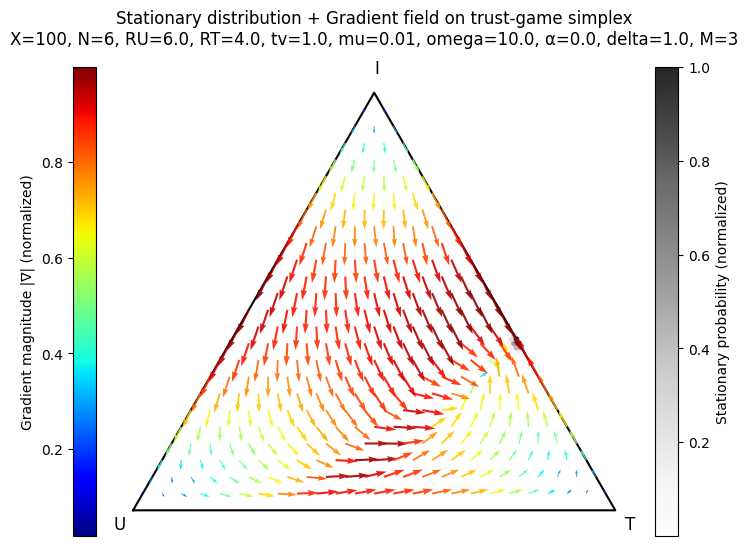

In [4]:
# this template can be used for figure 1 to 3

# Load results
data = np.load("results_part2.npz", allow_pickle=True)
states = data["states"]
x_stat = data["stationary"]
grad_I = data["grad_I"]
grad_T = data["grad_T"]
freq_I = data["freq_I"]
freq_T = data["freq_T"]
freq_U = data["freq_U"]
X = int(data["X"])
params = data["params"].item()

# ---- Simplex mapping (ρ_I, ρ_T, ρ_U → (x,y)) ----
# standard 2-simplex mapping (ρ_I, ρ_T, ρ_U) → (x,y)
# vertices: U=(0,0), T=(1,0), I=(0.5, sqrt(3)/2)
def simplex_to_xy(rI, rT, rU):
    x = rT + 0.5 * rI
    y = (np.sqrt(3)/2) * rI
    return x, y

x_coords, y_coords = simplex_to_xy(freq_I, freq_T, freq_U)

# Stationary distribution scaling
p_norm = x_stat / x_stat.max()

# ---- Gradient vectors ----
dU = -grad_I - grad_T
dx, dy = simplex_to_xy(grad_I, grad_T, dU)
grad_mag = np.sqrt(dx**2 + dy**2) / np.max(np.sqrt(dx**2 + dy**2)) # normalized

# ---- Downsample vector field ----
# define coarse grid spacing
step = 4  
mask = (states[:,0] % step == 0) & (states[:,1] % step == 0)

xs = x_coords[mask]
ys = y_coords[mask]
dxs = dx[mask]
dys = dy[mask]
gmag = grad_mag[mask]

# Normalize arrow length
dxs = dxs / np.max(np.abs(dxs)) * 0.05
dys = dys / np.max(np.abs(dys)) * 0.05

# ---- Figure setup ----
fig, ax = plt.subplots(figsize=(8,7))

# MAIN heatmap (background)
scatter = ax.scatter(
    x_coords, y_coords, 
    c=p_norm, cmap="Greys",
    s=10, alpha=0.85
)

# Right colorbar = stationary distribution
cbar_right = fig.colorbar(scatter, ax=ax, location="right", pad=0.02, shrink=0.7)
cbar_right.set_label("Stationary probability (normalized)")

# ---- Left colorbar = gradient magnitude ----
norm = Normalize(vmin=gmag.min(), vmax=gmag.max())
sm = ScalarMappable(norm=norm, cmap="jet")
cbar_left = fig.colorbar(sm, ax=ax, location="left", pad=0.02, shrink=0.7)
cbar_left.set_label("Gradient magnitude |∇| (normalized)")

# ---- Draw arrows with width proportional to gradient magnitude ----
# We draw arrows in "bins" of gradient magnitude so each bin gets its own width.
bins = 6
edges = np.linspace(gmag.min(), gmag.max(), bins+1)

for i in range(bins):
    lo, hi = edges[i], edges[i+1]
    sel = (gmag >= lo) & (gmag < hi)
    if np.sum(sel) == 0:
        continue
    
    width = 0.001 + 0.003 * (i / (bins - 1))  # varying arrow widths

    ax.quiver(
        xs[sel], ys[sel],
        dxs[sel], dys[sel],
        gmag[sel],
        cmap="jet",
        norm=norm,
        angles="xy",
        scale_units="xy",
        scale=1,
        width=width,
        alpha=0.9,
        zorder=5
    )

# ---- Draw triangle boundary ----
verts = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
ax.plot(verts[:,0], verts[:,1], 'k-', lw=1.5)

ax.text(-0.04, -0.04, "U", fontsize=12)
ax.text(1.02, -0.04, "T", fontsize=12)
ax.text(0.50, np.sqrt(3)/2 + 0.04, "I", fontsize=12)

ax.set_title(
    "Stationary distribution + Gradient field on trust-game simplex\n"
    f"X={X_param}, N={params['N']}, RU={params['RU']}, RT={params['RT']}, tv={params['tv']}, mu={mu_param}, omega={omega_param}, α={params['alpha']}, delta={params['delta']}, M={params['M']}"
    , pad=20
)

ax.set_aspect("equal")
ax.axis("off")

plt.tight_layout()
plt.show()


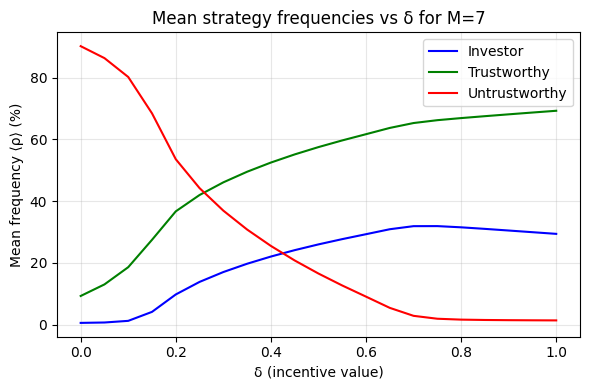

In [5]:
# Fig 4
# Sweep delta and plot mean frequencies (bar or line)

M=7  # or 3, or 7
# Suppose you saved multiple result files: results_delta0.1.npz, results_delta0.2.npz, ...
deltas = [i/20 for i in range(21)]  # 0.0 to 1.0 in steps of 0.05
rhoI_list, rhoT_list, rhoU_list = [], [], []

for d in deltas:
    fname = f"M={M}/delta_{d:.2f}.npz"
    if not os.path.exists(fname):
        fname = f"M={M}/delta_{d:.1f}.npz"
        if not os.path.exists(fname):
            print("missing", fname)
            continue
    data = np.load(fname, allow_pickle=True)
    rhoI_list.append(float(data["mean_rho_I"]))
    rhoT_list.append(float(data["mean_rho_T"]))
    rhoU_list.append(float(data["mean_rho_U"]))

plt.figure(figsize=(6,4))
plt.plot(deltas, np.array(rhoI_list) * 100, color='blue', label='Investor')
plt.plot(deltas, np.array(rhoT_list) * 100, color='green', label='Trustworthy')
plt.plot(deltas, np.array(rhoU_list) * 100, color='red', label='Untrustworthy')
plt.xlabel("δ (incentive value)")
plt.ylabel("Mean frequency ⟨ρ⟩ (%)")
plt.title(f"Mean strategy frequencies vs δ for M={M}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


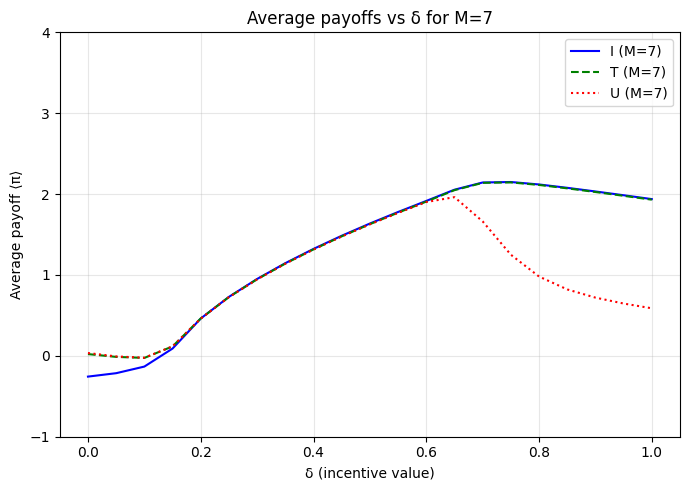

In [15]:
# Path where your NPZ result files are saved
chosen_M = 7  # or 3, or 7
folder = f"M={chosen_M}/"  # change if needed
files = sorted(glob.glob(folder + "delta_*.npz"))

# Storage
delta_values = []
M_values = []
meanFI = {}
meanFT = {}
meanFU = {}

# from ntg_part1 import expected_payoffs  # <-- reuse your payoff function

for fname in files:
    data = np.load(fname, allow_pickle=True)
    params = data["params"].item()
    delta = params["delta"]
    M = params["M"]
    
    # stationary distribution & states
    x = data["stationary"]
    states = data["states"]
    X = int(data["X"])
    
    # compute ⟨f_I⟩, ⟨f_T⟩, ⟨f_U⟩
    fI_avg = 0
    fT_avg = 0
    fU_avg = 0
    
    for idx, (iI, iT) in enumerate(states):
        fI, fT, fU = expected_payoffs(iI, iT, X, params)
        fI_avg += x[idx] * fI
        fT_avg += x[idx] * fT
        fU_avg += x[idx] * fU

    # store in dict indexed by M
    if M not in meanFI:
        meanFI[M] = []
        meanFT[M] = []
        meanFU[M] = []
    
    delta_values.append(delta)
    M_values.append(M)

    meanFI[M].append((delta, fI_avg))
    meanFT[M].append((delta, fT_avg))
    meanFU[M].append((delta, fU_avg))


# ---- Plotting ----
plt.figure(figsize=(7,5))

for M in sorted(meanFI.keys()):
    arr = np.array(meanFI[M])
    arrT = np.array(meanFT[M])
    arrU = np.array(meanFU[M])
    
    plt.plot(arr[:,0], arr[:,1], '-', color = "blue", label=f'I (M={M})')
    plt.plot(arrT[:,0], arrT[:,1], '--', color = "green", label=f'T (M={M})')
    plt.plot(arrU[:,0], arrU[:,1], ':', color = "red", label=f'U (M={M})')

plt.xlabel("δ (incentive value)")
plt.ylabel("Average payoff ⟨π⟩")
plt.ylim(-1, 4)
plt.title(f"Average payoffs vs δ for M={chosen_M}")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
X_param = 100
mu_param = 0.01
omega_param = 10.0

# If run as script, run with default parameters
if __name__ == "__main__":
    # Example: use X=100 (this creates ~5151 states)
    # NOTE: for large X this can take some time & memory; adjust X as needed.
    # out = main_compute_and_save(X=X_param,
    #                             params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':1.0, 'alpha':0.0, 'M':3},
    #                             mu=mu_param, omega=omega_param,
    #                             out_filename="results_part2.npz")
    # print("Done. Output file:", out)

    # Running multiple times to generate several output files
    resolution_runs = 5
    for i in range(resolution_runs):
        out = main_compute_and_save(X=X_param,
                                params={'RT':4.0, 'RU':6.0, 'N':6 + 2*i, 'tv':1.0, 'delta':0.2, 'alpha':0.0, 'M':0},
                                mu=mu_param, omega=omega_param,
                                out_filename=f"M=0/N_{6 + 2*i}.npz")
        # out = main_compute_and_save(X=X_param,
        #                         params={'RT':4.0, 'RU':6.0, 'N':6 + 2*i, 'tv':1.0, 'delta':0.2, 'alpha':0.0, 'M':(6 + 2*i)/2},
        #                         mu=mu_param, omega=omega_param,
        #                         out_filename=f"M=N2/N_{6 + 2*i}.npz")
        # out = main_compute_and_save(X=X_param,
        #                         params={'RT':4.0, 'RU':6.0, 'N':6 + 2*i, 'tv':1.0, 'delta':0.2, 'alpha':0.0, 'M':(6 + 2*i)+1},
        #                         mu=mu_param, omega=omega_param,
        #                         out_filename=f"M=N1/N_{6 + 2*i}.npz")
        print("Done. Output file:", out)
    print("Done. All")


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 14187.77it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.394e-03
iter 200, L1 diff = 4.995e-03
iter 400, L1 diff = 3.710e-03
iter 600, L1 diff = 2.031e-03
iter 800, L1 diff = 1.058e-03
iter 1000, L1 diff = 6.011e-04
iter 1200, L1 diff = 3.528e-04
iter 1400, L1 diff = 2.171e-04
iter 1600, L1 diff = 1.515e-04
iter 1800, L1 diff = 1.205e-04
iter 2000, L1 diff = 1.011e-04
converged in 2015 iterations, diff=9.99e-05
Stationary dist computed (took 29.2s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.011177, <rho_T>=0.147437, <rho_U>=0.841386
Saved results to M=0/N_6.npz (took 1.2s). Total time 30.7s
Done. Output file: M=0/N_6.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 8084.12it/s]


P built: shape=(5151, 5151)  (took 0.6s)
iter 0, L1 diff = 9.049e-03
iter 200, L1 diff = 4.959e-03
iter 400, L1 diff = 3.054e-03
iter 600, L1 diff = 1.345e-03
iter 800, L1 diff = 5.902e-04
iter 1000, L1 diff = 3.451e-04
iter 1200, L1 diff = 2.438e-04
iter 1400, L1 diff = 1.762e-04
iter 1600, L1 diff = 1.310e-04
iter 1800, L1 diff = 1.011e-04
converged in 1810 iterations, diff=9.99e-05
Stationary dist computed (took 25.9s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.079872, <rho_T>=0.237523, <rho_U>=0.682605
Saved results to M=0/N_8.npz (took 1.2s). Total time 27.7s
Done. Output file: M=0/N_8.npz


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 5693.74it/s]


P built: shape=(5151, 5151)  (took 0.9s)
iter 0, L1 diff = 8.881e-03
iter 200, L1 diff = 5.311e-03
iter 400, L1 diff = 3.139e-03
iter 600, L1 diff = 1.130e-03
iter 800, L1 diff = 3.010e-04
converged in 990 iterations, diff=9.99e-05
Stationary dist computed (took 14.3s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.170047, <rho_T>=0.325653, <rho_U>=0.504300
Saved results to M=0/N_10.npz (took 1.2s). Total time 16.4s
Done. Output file: M=0/N_10.npz


Building P: 100%|██████████| 5151/5151 [00:01<00:00, 3677.88it/s]


P built: shape=(5151, 5151)  (took 1.4s)
iter 0, L1 diff = 8.805e-03
iter 200, L1 diff = 5.336e-03
iter 400, L1 diff = 3.047e-03
iter 600, L1 diff = 1.097e-03
iter 800, L1 diff = 3.228e-04
iter 1000, L1 diff = 1.738e-04
iter 1200, L1 diff = 1.519e-04
iter 1400, L1 diff = 1.426e-04
iter 1600, L1 diff = 1.360e-04
iter 1800, L1 diff = 1.299e-04
iter 2000, L1 diff = 1.239e-04
iter 2200, L1 diff = 1.181e-04
iter 2400, L1 diff = 1.126e-04
iter 2600, L1 diff = 1.074e-04
iter 2800, L1 diff = 1.024e-04
converged in 2903 iterations, diff=1.00e-04
Stationary dist computed (took 41.6s); sum(x)=1.000000000000
Mean frequencies: <rho_I>=0.250999, <rho_T>=0.412913, <rho_U>=0.336089
Saved results to M=0/N_12.npz (took 1.1s). Total time 44.1s
Done. Output file: M=0/N_12.npz


Building P:  95%|█████████▍| 4872/5151 [00:01<00:00, 3088.71it/s]C:\Users\Dell\AppData\Local\Temp\ipykernel_19848\3853884823.py:164: RuntimeWarning: overflow encountered in exp
  imitation = (iA / X) * (iB / (X - 1)) * (1.0 / (1.0 + np.exp(-omega * (fB - fA))))
Building P: 100%|██████████| 5151/5151 [00:01<00:00, 3118.01it/s]


P built: shape=(5151, 5151)  (took 1.7s)
iter 0, L1 diff = 8.745e-03
iter 200, L1 diff = 5.288e-03
iter 400, L1 diff = 3.013e-03
iter 600, L1 diff = 1.115e-03
iter 800, L1 diff = 3.422e-04
iter 1000, L1 diff = 2.260e-04
iter 1200, L1 diff = 2.063e-04
iter 1400, L1 diff = 1.979e-04
iter 1600, L1 diff = 1.923e-04
iter 1800, L1 diff = 1.877e-04
iter 2000, L1 diff = 1.830e-04
iter 2200, L1 diff = 1.782e-04
iter 2400, L1 diff = 1.733e-04
iter 2600, L1 diff = 1.684e-04
iter 2800, L1 diff = 1.635e-04
iter 3000, L1 diff = 1.586e-04
iter 3200, L1 diff = 1.538e-04
iter 3400, L1 diff = 1.490e-04
iter 3600, L1 diff = 1.443e-04
iter 3800, L1 diff = 1.396e-04
iter 4000, L1 diff = 1.350e-04
iter 4200, L1 diff = 1.305e-04
iter 4400, L1 diff = 1.261e-04
iter 4600, L1 diff = 1.218e-04
iter 4800, L1 diff = 1.175e-04
iter 5000, L1 diff = 1.134e-04
iter 5200, L1 diff = 1.093e-04
iter 5400, L1 diff = 1.054e-04
iter 5600, L1 diff = 1.016e-04
converged in 5683 iterations, diff=1.00e-04
Stationary dist compute

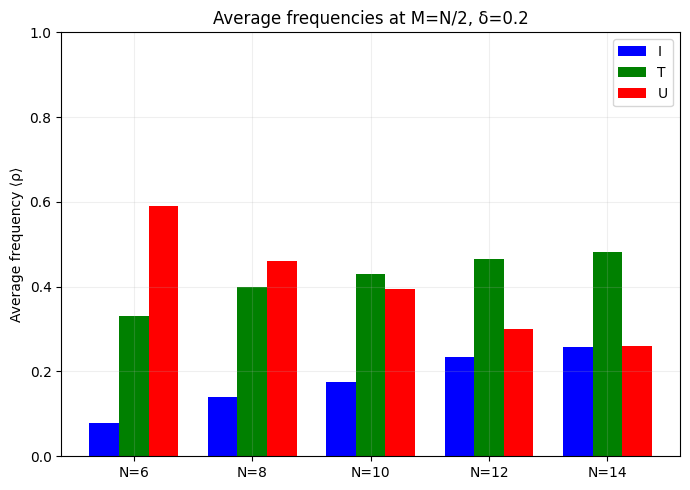

In [23]:
# choose your 3 M-values and delta
target_M = "N/2" # "0" or "N+1" or "N/2"
N_list = [6+2*i for i in range(5)]  # example

rhoI_vals = []
rhoT_vals = []
rhoU_vals = []

for N in N_list:
    if(target_M == "0"):
        fname = f"M=0/N_{N}.npz"
    elif(target_M == "N+1"):
        fname = f"M=N1/N_{N}.npz"
    else: # N/2
        fname = f"M=N2/N_{N}.npz"
    data = np.load(fname, allow_pickle=True)
    
    rhoI_vals.append(float(data["mean_rho_I"]))
    rhoT_vals.append(float(data["mean_rho_T"]))
    rhoU_vals.append(float(data["mean_rho_U"]))

# ---- Bar chart ----
x = np.arange(len(N_list))
width = 0.25

plt.figure(figsize=(7,5))
plt.bar(x - width, rhoI_vals, width, color='blue', label='I')
plt.bar(x,         rhoT_vals, width, color='green', label='T')
plt.bar(x + width, rhoU_vals, width, color='red', label='U')

plt.xticks(x, [f"N={N}" for N in N_list])
plt.ylim(0, 1)
plt.ylabel("Average frequency ⟨ρ⟩")
plt.title(f"Average frequencies at M={target_M}, δ=0.2")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_3160\3480158501.py:3: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-omega[:, None] * x))


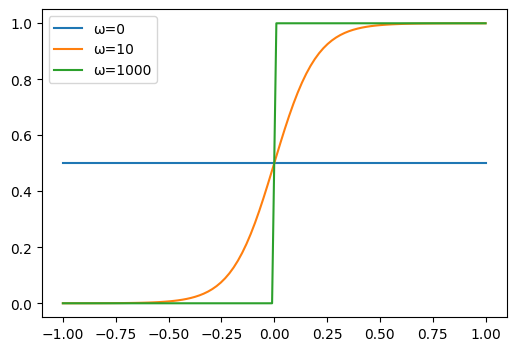

In [6]:
omega = np.array([0, 10, 1000])
x = np.linspace(-1, 1, 100)
y = 1 / (1 + np.exp(-omega[:, None] * x))
plt.figure(figsize=(6,4))
for i in range(len(omega)):
    plt.plot(x, y[i,:], label=f"ω={omega[i]}")
plt.legend()
plt.show()